# Peer-graded Assignment

## Capstone Project - The Battle of Neighborhoods

### Modules

In [1]:
import requests
import os
import pandas as pd
import seaborn as sns
import numpy as np
import folium
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### Constants

In [2]:
VERSION = '20190630'
BOURNEMOUTH = (50.721680, -1.878530)
RADIUS = 1500
LIMIT = 100
ZOOM = 15

COL_LAT = 'Latitude'
COL_LNG = 'Longitude'
COL_VENUE_NAME = 'Venue Name'
COL_VENUE_LAT = 'Venue Latitude'
COL_VENUE_LNG = 'Venue Longitude'
COL_VENUE_CAT = 'Venue Category'
COL_VENUE_GRP = 'Venue Group'
COL_VENUE_CLS = 'Venue Cluster'

DRINK = 'Drink'
ENTERTAINMENT = 'Entertainment'
FOOD = 'Food'
HOTEL = 'Hotel'
SHOPPING = 'Shopping'
TRANSPORT = 'Transport'

### Functions

We use `fsq_id_secret` to fetch our Foursquare `client_id` and `client_secret` from external files that are not included in this notebook,
in order to keep the information private.

In [3]:
def fsq_id_secret():
    with open(os.path.join('..', 'data', 'client_id.txt')) as f: c_id = f.read()
    with open(os.path.join('..', 'data', 'client_secret.txt')) as f: c_secret = f.read()
    
    return c_id, c_secret

We use `fsq_venue` to fetch Foursquare venue information and convert it into a data frame.

In [4]:
def fsq_venue(c_id, c_secret, version, lat, lng, radius, limit):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
    
    items = requests.get(url.format(
        c_id, c_secret, version, lat, lng, radius, limit
    )).json()["response"]['groups'][0]['items']
    
    rows = []
    for item in items:
        venue = item['venue']
        rows.append({
            COL_VENUE_NAME: venue['name'],
            COL_VENUE_CAT: venue['categories'][0]['name'],
            COL_VENUE_LAT: venue['location']['lat'],
            COL_VENUE_LNG: venue['location']['lng']
        })
        
    return pd.DataFrame(rows, columns=[COL_VENUE_NAME, COL_VENUE_CAT, COL_VENUE_LAT, COL_VENUE_LNG])

We use `make_color_palette` to create a list of hex colors.

In [5]:
def make_color_palette(size, n_min=50, n_max=205):
    r = lambda: hex(randint(0, 255))[2:]
    colors = []
    
    while len(colors) < size:
        c = '#{}{}{}'.format(r(), r(), r())
        
        if c not in colors:
            colors.append(c)
    
    return colors

We use `generate_map` to visualise venue information.

In [6]:
def generate_map(df, lat, lng, zoom, col_lat, col_lng,
                 col_popup=None, popup_colors=False, def_color='red',
                 tiles='cartodbpositron'):
    folmap = folium.Map(location=[lat, lng], zoom_start=zoom, tiles=tiles)
    
    popup = list(df[col_popup].unique())
    
    if popup_colors:
        colors = make_color_palette(len(popup))
    
    for index, row in df.iterrows():
        folium.CircleMarker(
            location=(row[col_lat], row[col_lng]),
            radius=6,
            popup=row[col_popup] if col_popup is not None else '',
            fill=True,
            color=colors[popup.index(row[col_popup])] if popup_colors else def_color,
            fill_opacity=0.6
            ).add_to(folmap)
    
    return folmap

### Foursquare Venue Data

The following code was executed to get venue data from Foursquare and we saved the output to file `week5_venues.csv`.     

In [7]:
#client_id, client_secret = fsq_id_secret()
#df_venue = fsq_venue(client_id, client_secret, VERSION, BOURNEMOUTH[0], BOURNEMOUTH[1], RADIUS, LIMIT)
#df_venue.to_csv(os.path.join('..', 'data', 'week5_venues.csv'), index=False)

We will get venue data from `week5_venues.csv`, instead of pulling live data from Foursquare, so that
our `client_id` and `client_secret` can remain private.

In [8]:
df_venues = pd.read_csv(os.path.join('..', 'data', 'week5_venues.csv'))
print(df_venues.shape)
df_venues.head()

(100, 4)


,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,South Coast Roast,Coffee Shop,50.720913,-1.879085
1,DelMarco,Italian Restaurant,50.721370,-1.877221
2,Lower Gardens,Park,50.719323,-1.878195
3,Bournemouth Gardens,Park,50.718990,-1.877733
4,Bournemouth Square,Plaza,50.720156,-1.879563


Let's quickly visualise the venues in Bournemouth.

In [9]:
generate_map(df_venues, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG, col_popup=COL_VENUE_NAME)

### Venue Groups

How many different types of venue category have been returned?

In [10]:
venue_cat = df_venues[COL_VENUE_CAT].unique()
venue_cat.sort()

print('Venues:', len(venue_cat))
venue_cat

Venues: 51


array(['Aquarium', 'Art Museum', 'Arts & Entertainment', 'Bar', 'Beach',
       'Brewery', 'Bubble Tea Shop', 'Burger Joint', 'Bus Stop', 'Café',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Clothing Store',
       'Cocktail Bar', 'Coffee Shop', 'Comfort Food Restaurant',
       'Dessert Shop', 'Diner', 'English Restaurant',
       'Fast Food Restaurant', 'French Restaurant', 'Garden', 'Gay Bar',
       'Greek Restaurant', 'Grocery Store', 'Gym', 'Gym / Fitness Center',
       'Hotel', 'Ice Cream Shop', 'Indian Restaurant',
       'Italian Restaurant', 'Mexican Restaurant',
       'Modern European Restaurant', 'Multiplex', 'Nightclub',
       'Noodle House', 'Other Great Outdoors', 'Park', 'Pizza Place',
       'Platform', 'Plaza', 'Pub', 'Sandwich Place', 'Scenic Lookout',
       'Seafood Restaurant', 'Tapas Restaurant', 'Thai Restaurant',
       'Theater', 'Train Station', 'Turkish Restaurant',
       'Vegetarian / Vegan Restaurant'], dtype=object)

This is quite a lot!
Let's put these categories into six high-level groups: `Drink`, `Entertainment`, `Food`, `Hotel`, `Shopping`, and `Transport`.

In [11]:
def change_group(grp_from_list, grp_to):
    for grp_from in grp_from_list:
        df_venues.loc[df_venues[COL_VENUE_GRP] == grp_from, COL_VENUE_GRP] = grp_to

# Quickly set venue groups to the last word in each venue category
df_venues[COL_VENUE_GRP] = df_venues[COL_VENUE_CAT].str.split(' ').str[-1]

# Remove the train station platform venue because we already have the nearby train station
df_venues = df_venues[df_venues[COL_VENUE_GRP] != 'Platform']

# Change groups into more high-level groups
change_group(['Bar', 'Brewery', 'Nightclub', 'Pub'],
             DRINK)

change_group(['Aquarium', 'Beach', 'Center', 'Garden', 'Gym', 'Lookout',
              'Multiplex', 'Museum', 'Outdoors', 'Park', 'Theater'],
             ENTERTAINMENT)

change_group(['Café', 'Diner', 'House', 'Joint', 'Place', 'Restaurant'],
             FOOD)

change_group(['Plaza', 'Shop', 'Store'],
             SHOPPING)

change_group(['Station', 'Stop'],
             TRANSPORT)

venue_grp = df_venues[COL_VENUE_GRP].unique()
venue_grp.sort()

print('Venues:', len(venue_grp))
venue_grp

Venues: 6


array(['Drink', 'Entertainment', 'Food', 'Hotel', 'Shopping', 'Transport'],
      dtype=object)

Now we graph venues based upon their new group instead.
We see that `Entertainment` venus are closer to the beach, and most `Food` and `Drink` cluster in the center of town, along with all of the `Shopping` venues.
`Hotel` venues are dispersed across town, and `Transport` is the furthest out of town.

In [12]:
generate_map(df_venues, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG,
             col_popup=COL_VENUE_GRP, popup_colors=True)

### Density-Based Clustering

Let's now perform a density-based clustering to locate areas of high venue density.
We will use the **DBSCAN** data clustering algorithm for this task.

In [13]:
df_latlng = df_venues[[COL_VENUE_LAT, COL_VENUE_LNG]]
df_latlng.head()

,Venue Latitude,Venue Longitude
0,50.720913,-1.879085
1,50.721370,-1.877221
2,50.719323,-1.878195
3,50.718990,-1.877733
4,50.720156,-1.879563


We scale the latitude and longitude data, so that DBSCAN can interpret these data without losing relative distances between venues.

In [14]:
latlng = StandardScaler().fit_transform(np.nan_to_num(df_latlng))
latlng[:5]

array([[ 0.21175769,  0.00286863],
       [ 0.3479356 ,  0.22777211],
       [-0.26138167,  0.11024611],
       [-0.36059201,  0.16601652],
       [-0.01346017, -0.05480564]])

We train the DBSCAN model, which generates `8` labels, as well as the outlier label `-1`.

In [15]:
dbscan = DBSCAN(eps=0.2, min_samples=3)
dbscan.fit(latlng)

print('labels:', np.unique(dbscan.labels_))

labels: [-1  0  1  2  3  4  5  6  7]


We add the labels to the data frame as `Venue Cluster`.

In [16]:
df_venues[COL_VENUE_CLS] = dbscan.labels_
df_venues.head()

,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue Group,Venue Cluster
0,South Coast Roast,Coffee Shop,50.720913,-1.879085,Shopping,0
1,DelMarco,Italian Restaurant,50.721370,-1.877221,Food,1
2,Lower Gardens,Park,50.719323,-1.878195,Entertainment,0
3,Bournemouth Gardens,Park,50.718990,-1.877733,Entertainment,0
4,Bournemouth Square,Plaza,50.720156,-1.879563,Shopping,0


Now, we map the venues again, but color code them by the cluster value they've been assigned.

In [17]:
generate_map(df_venues, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG,
             col_popup=COL_VENUE_CLS, popup_colors=True)

### Cluster Analysis

Let's check which clusters are the most densely populated.

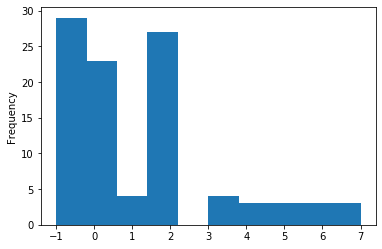

In [18]:
df_venues[COL_VENUE_CLS].plot(kind='hist')

We see that, outside of the outlier class `-1`, the two most densely populated clusters are `0` and `2`, which are both in the center of town.
Let's put these into their own separate data frames.

In [19]:
df_0 = df_venues.loc[df_venues[COL_VENUE_CLS] == 0]
df_2 = df_venues.loc[df_venues[COL_VENUE_CLS] == 2]

print('df_0:', df_0.shape)
print('df_2:', df_2.shape)

df_0: (23, 6)
df_2: (27, 6)


### Which Cluster?

We have identified the two largest venue clusters in Bournemouth.
Now, we want to analyse the venue distribution within each cluster, to help us reason about which cluster we should open our own Fish & Chips shop in.
We create two bar charts showing venue frequency per clusters `0` and `2`.

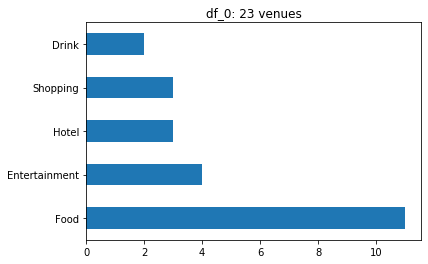

In [20]:
df_0[COL_VENUE_GRP].value_counts().plot(kind='barh', title='df_0: ' + str(df_0.shape[0]) + ' venues')

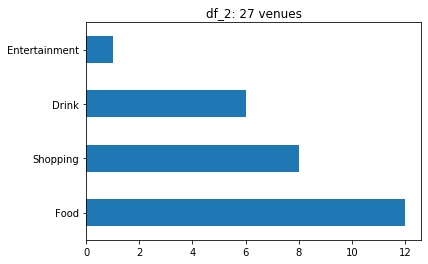

In [21]:
df_2[COL_VENUE_GRP].value_counts().plot(kind='barh', title='df_2: ' + str(df_2.shape[0]) + ' venues')

We see that, of the two clusters, cluster `0` has fewer `Food` venues, which is desirable, but is only marginally lower than the `Food` venues in `2`.
However, cluster `2` has a more non-`Food` venues than `0`, which is more preferable.
Areas with many places to `Drink` are a hotspot for Fish & Chips food after a night of drinking, and people who do `Shopping` in the day time might like to eat Fish & Chips for lunch or dinner.

In conclusion, we would want to open our Fish & Chips shop in cluster `2`, given that it is densely popular with venues that are not `Food` related, despite having slightly more `Food` venues than cluster `0`.